In [10]:
%pip uninstall numpy -y
%pip install "numpy<2"
%pip install pyarrow

Found existing installation: numpy 1.26.4


Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt

categorical = ["PULocationID", "DOLocationID"]

In [2]:
def preprocess_data(filename, categorical_cols=[]):
    df = pd.read_parquet(filename)
    df[categorical_cols] = df[categorical_cols].astype(str)
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
    dur_std_dev = round(df.duration.describe().loc['std'], 2)
    total_prefilter = len(df)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    total_postfilter = len(df)
    total_postfilter_percent = round((total_postfilter/total_prefilter) * 100)
    return {'df':df, 'postfilter_fraction': total_postfilter_percent, 'dur_std_dev': dur_std_dev}
    

In [3]:
df_train = preprocess_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet', categorical_cols=categorical)
df_val = preprocess_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet', categorical_cols=categorical)

print(f'January columns count (incl. "duration"): {len(df_train["df"].columns)}')
print(f'Standard deviation of trip durations: {df_train["dur_std_dev"]}')
print(f'Fraction of records left: {df_train["postfilter_fraction"]}%')

df_train = df_train['df']
df_val = df_val['df']

January columns count (incl. "duration"): 20
Standard deviation of trip durations: 42.59
Fraction of records left: 98%


In [4]:
dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
print(f'Dimensiality of train matrix (OHE): {len(dv.feature_names_)}')

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)
print(f'Dimensiality of validation matrix (OHE): {len(dv.feature_names_)}')



Dimensiality of train matrix (OHE): 515
Dimensiality of validation matrix (OHE): 514


In [5]:
lr = LinearRegression()

Y_train = df_train['duration'].values
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_train)

print(f'RMSE on train (LinearRegression): {sqrt(mean_squared_error(Y_train, Y_pred)):.2f}')

Y_val = df_val['duration'].values
lr.fit(X_val, Y_val)
Y_pred = lr.predict(X_val)

print(f'RMSE of validation (LinearRegression): {sqrt(mean_squared_error(Y_val, Y_pred)):.2f}')

RMSE on train (LinearRegression): 7.65
RMSE of validation (LinearRegression): 7.78


In [6]:
ls = Lasso()

Y_train = df_train['duration'].values
ls.fit(X_train, Y_train)
Y_pred = ls.predict(X_train)

print(f'RMSE on train (Lasso): {sqrt(mean_squared_error(Y_train, Y_pred)):.2f}')

Y_val = df_val['duration'].values
ls.fit(X_val, Y_val)
Y_pred = ls.predict(X_val)

print(f'RMSE of validation (Lasso): {sqrt(mean_squared_error(Y_val, Y_pred)):.2f}')

RMSE on train (Lasso): 9.94
RMSE of validation (Lasso): 10.06


In [7]:
lrid = Ridge()

Y_train = df_train['duration'].values
lrid.fit(X_train, Y_train)
Y_pred = lrid.predict(X_train)

print(f'RMSE on train (Ridge): {sqrt(mean_squared_error(Y_train, Y_pred)):.2f}')

Y_val = df_val['duration'].values
lrid.fit(X_val, Y_val)
Y_pred = lrid.predict(X_val)

print(f'RMSE of validation (Ridge): {sqrt(mean_squared_error(Y_val, Y_pred)):.2f}')

RMSE on train (Ridge): 7.65
RMSE of validation (Ridge): 7.78


In [ ]:
import pickle
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr, ls, lrid), f_out)

/tmp/ipykernel_2208/4091541199.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_pred, label='Prediction')


/tmp/ipykernel_2208/4091541199.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_train, label='actual')


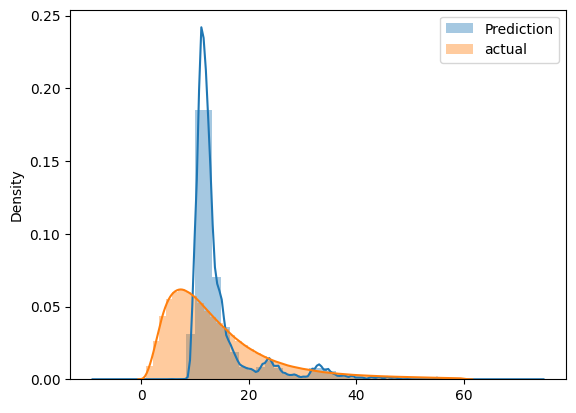

In [8]:
sns.distplot(Y_pred, label='Prediction')
sns.distplot(Y_train, label='actual')

plt.legend()